In [1]:
from ai_models_fourcastnetv2 import model as sfno
import h5py
import os
import cfgrib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import numpy as np
import xarray as xr

In [2]:
os.chdir('/home/jovyan/fourcastnetv2')

# Generate FourCastNetv2 prediction

Create a prediction using ECMWF ```ai-models``` plugin. Follow the README.md in the repository https://github.com/ikhadir/FCN4AWS. Make sure you are working in the same directory where the output is located.

The github includes a bash script that 

1) Creates a fourcastnetv2 directory
2) Creates a .cdsapirc directory and fills it with a login and key template for https://cds.climate.copernicus.eu/
3) Installs cdsapirc
4) Downloads normalization files using curl
5) Installs the ECMWF ai-models plugin

Here are initial condition dates for a few Hurricanes you may wish to track. Enter the following command line prompts to initiate a 40 step prediction.

Hurricane Erin(2025): ```ai-models --input cds --date 20250816 --time 0000 fourcastnetv2-small```

Hurricane Harvey(2017): ```ai-models --input cds --date 20170824 --time 0000 fourcastnetv2-small```

Hurricane Katrina(2005): ```ai-models --input cds --date 20170825 --time 0000 fourcastnetv2-small```

Hurricane Patricia(2015): ```ai-models --input cds --date 20151020 --time 0000 fourcastnetv2-small```

Hurricanes Jose, Maria, and Lee(2017): ```ai-models --input cds --date 20170916 --time 0000 fourcastnetv2-small```

Typhoon Paolo (2025): ```ai-models --input cds --date 20251002 --time 0000 fourcastnetv2-small```

If ```ai-models``` gives an error that the command is not found but all requirements are satisfied then run ```export PATH=$HOME/.local/bin:$PATH```

In [3]:
# Path to your GRIB file, typically a fourcastnetv2 prediction
grib_file = "era5_fcnv2_20250919_0000.grib2"

# Load the GRIB file using xarray
ds = xr.open_dataset(grib_file, engine='cfgrib')

# Display the dataset structure
#print(ds)

# Check the shape of a specific variable
#for var in ds.data_vars:
  #  print(f"Shape of '{var}': {ds[var].shape}")



Can't read index file 'era5_fcnv2_20250919_0000.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.10/site-packages/cfgrib/messages.py", line 551, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/jovyan/.local/lib/python3.10/site-packages/cfgrib/messages.py", line 430, in from_indexpath
    index = pickle.load(file)
EOFError: Ran out of input
skipping variable: paramId==228246 shortName='u100'
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/jovyan/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=10.0) new_value=Variable(dimensions=(), data=100.0)
skipping variable: pa

# Plot Predicted Variables

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd

variable_info = {
    'u10': {'name': '10m Wind Speed', 'unit': 'm/s'},
    'v10': {'name': '10m Wind Speed', 'unit': 'm/s'},
    'msl': {'name': 'Mean Sea Level Pressure', 'unit': 'hPa'},
    'sp': {'name': 'Surface Pressure', 'unit': 'hPa'},
    't': {'name': 'Temperature', 'unit': 'K'}  # Adjust unit if needed (e.g., °C)
}

def robinson_predictions_plot(predictions, variable, t, huh=False):
    dat = predictions[variable].values[t]
    if huh:
        dat = predictions[variable].values[t][0]
    print(dat.shape)

    if variable == 'sp' or variable == 'prmsl' or variable == 'msl':
        dat = predictions[variable].values[t]/100
    
    # Create subplots with the Robinson projection centered on the Pacific (central_longitude=180)
    central_longitude = 180
    projection = ccrs.Robinson(central_longitude=central_longitude)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), subplot_kw={'projection': projection})
    
    # Define the extent of the map (in degrees)
    extent = (-180, 180, -90, 90)
   # extent = [-82, -65, 15, 50]
    
    # Define the color limits
    vmin, vmax = 970, 1020

    # Grab times from the dataset
    ic_dt = pd.to_datetime(ds.time.values)                      # scalar IC time (UTC)
    lead_hours = int(ds.step.values[t] / np.timedelta64(1, 'h'))  # lead in hours for frame t
    valid_dt = pd.to_datetime(ds.valid_time.values[t])          # valid time for frame t (UTC)
    
    # Nice strings
    ic_str = ic_dt.strftime("%Y-%m-%d %H:%M UTC")
    valid_str = valid_dt.strftime("%Y-%m-%d %H:%M UTC")
    
    # Plot the prediction data
    ax.set_global()
    im1 = ax.imshow(np.roll(dat, shift=dat.shape[-1]//2, axis=-1), 
                       transform=ccrs.PlateCarree(central_longitude=180), 
                       cmap="jet", extent=extent, origin='upper')#, vmin=vmin, vmax=vmax)
    ax.coastlines()
    ax.set_title(f"FourCastNetv2 {t * 6} Hour Prediction of {variable} from {ic_str}", fontsize=16)
    
    var_name = variable_info.get(variable, {}).get('name', variable)
    var_unit = variable_info.get(variable, {}).get('unit', '')

    # Add colorbar with dynamic label
    cbar = fig.colorbar(im1, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
    cbar.set_label(f"{var_name} ({var_unit})", fontsize=12)
    
    for i in np.arange(2):
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False

    #plt.savefig(f'FourCastNetv2_prediction_{variable}_Dec_25_2024_{t * 6}_hours_from_initialization.png')
    fig.tight_layout()
    plt.show()

(721, 1440)


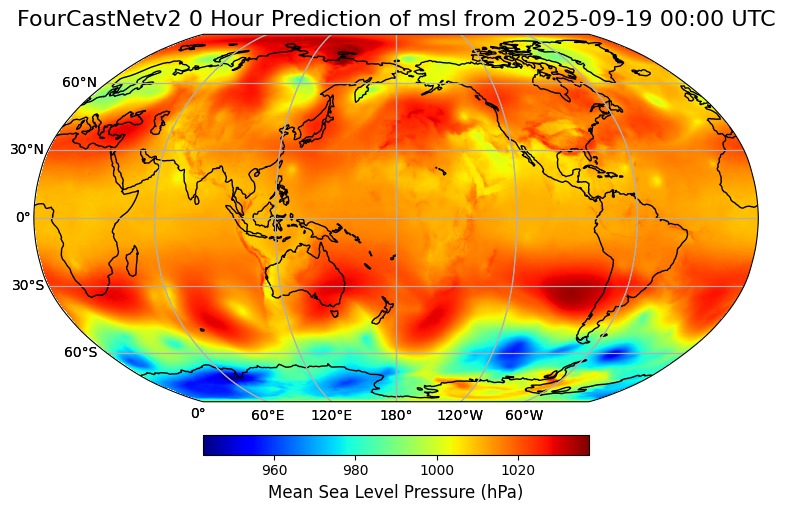

(721, 1440)


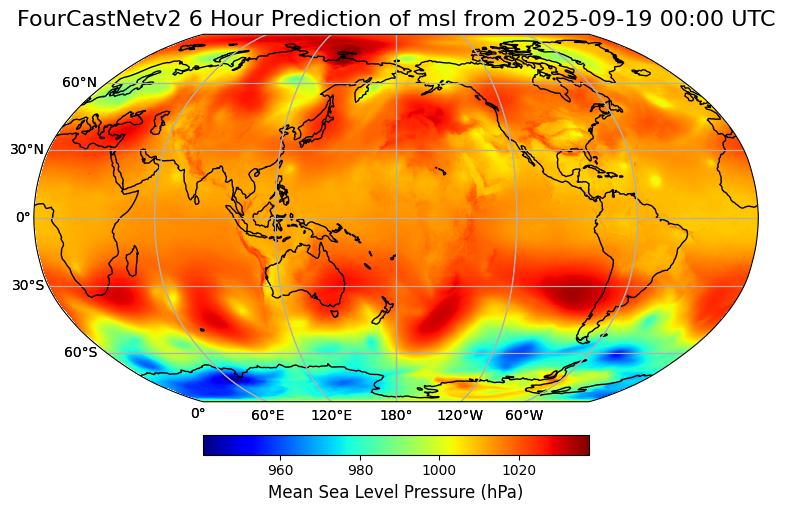

(721, 1440)


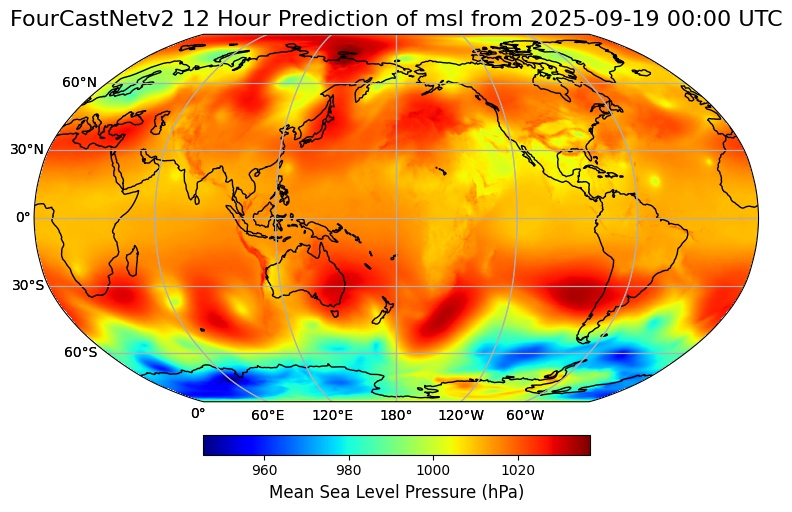

In [5]:
robinson_predictions_plot(ds, 'msl', 0)
robinson_predictions_plot(ds, 'msl', 1)
robinson_predictions_plot(ds, 'msl', 2)

Find the latitutde and longitute points for the event and name it ```extent```. Depending on the pressure level during the event you will want to adjust the ```vmax``` and ```vmin``` so the color map is scaled appropriately in the gif. If you do not want to use the gif or you don't mind a dynamic color bar then just remove those variables. Search online for the lowest pressure level for the weather event to determine an adequate minimum.

# Plot MSLP to Visualize Hurricane

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd

variable_info = {
    'u10': {'name': '10m Wind Speed', 'unit': 'm/s'},
    'v10': {'name': '10m Wind Speed', 'unit': 'm/s'},
    'msl': {'name': 'Mean Sea Level Pressure', 'unit': 'hPa'},
    'sp': {'name': 'Surface Pressure', 'unit': 'hPa'},
    't': {'name': 'Temperature', 'unit': 'K'}  # Adjust unit if needed
}

def hurricane_prediction_plot(predictions, variable, t, huh=False):
    # Get prediction data
    dat = predictions[variable].values[t]
    if huh:
        dat = predictions[variable].values[t][0]
    print(f"Data shape: {dat.shape}")

    # Convert pressure from Pa to hPa if needed
    if variable in ['sp', 'msl','prmsl']:
        dat = dat / 100

    # Define map projection for regional plot
    projection = ccrs.PlateCarree()

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})

    # Set extent to zoom in on desired region
    #KATRINA 2005
    #extent = [-98, -70, 21, 44]  # [lon_min, lon_max, lat_min, lat_max]
    #ERIN 2025
    #extent = [-85, -60, 17, 41]
    #HARVEY 2017
    #extent = [-105,-70,17,40]
    #PATRICIA 2015
    #extent = [-120,-95,10,30]
    #MARIA 2017
    #extent = [-85,-30,10,45]
    #RAGASA
    extent = [95, 145, 0, 36]
    #russia
    #extent = [50,120,30,90]
    #carribean
    #extent = [-95, -55, 5, 35]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographic features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)

    # Plot the variable
    im = ax.imshow(dat, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(),
                   cmap="jet", origin='upper')#,vmin=985,vmax=1020)
    lons = predictions.longitude.values
    lats = predictions.latitude.values
    lon2d, lat2d = np.meshgrid(lons, lats)
    
    im = ax.pcolormesh(lon2d, lat2d, dat, transform=ccrs.PlateCarree(),
                       cmap="jet", shading="auto")#,vmin=990,vmax=1025)

    
    
    # Grab times from the dataset
    ic_dt = pd.to_datetime(ds.time.values)                      # scalar IC time (UTC)
    lead_hours = int(ds.step.values[t] / np.timedelta64(1, 'h'))  # lead in hours for frame t
    valid_dt = pd.to_datetime(ds.valid_time.values[t])          # valid time for frame t (UTC)
    
    # Nice strings
    ic_str = ic_dt.strftime("%Y-%m-%d %H:%M UTC")
    valid_str = valid_dt.strftime("%Y-%m-%d %H:%M UTC")
    
    ax.set_title(
        f"FourCastNetv2 {lead_hours}hr ({valid_str}) Prediction of {variable} "
        f"from IC: {ic_str}",
        fontsize=12
    )
    var_name = variable_info.get(variable, {}).get('name', variable)
    var_unit = variable_info.get(variable, {}).get('unit', '')
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
    cbar.set_label(f"{var_name} ({var_unit})", fontsize=12)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.tight_layout()
    plt.show()


Data shape: (721, 1440)


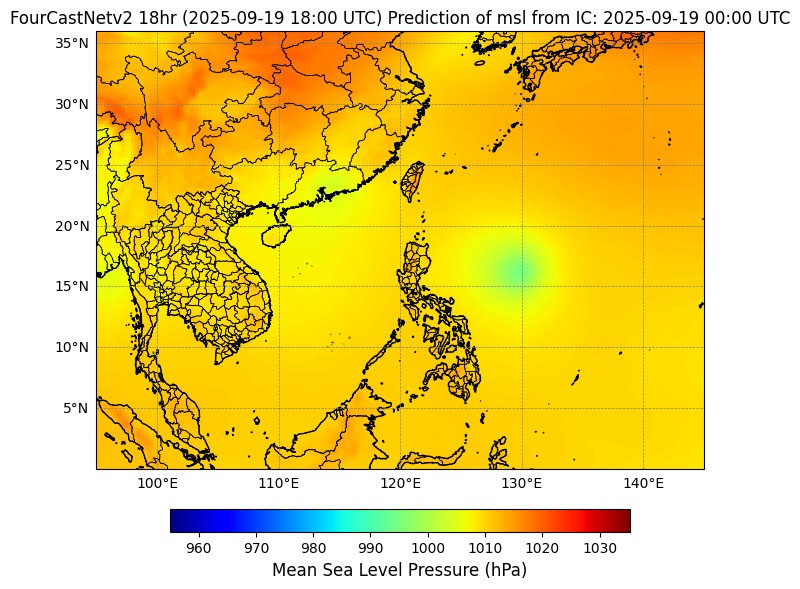

Data shape: (721, 1440)


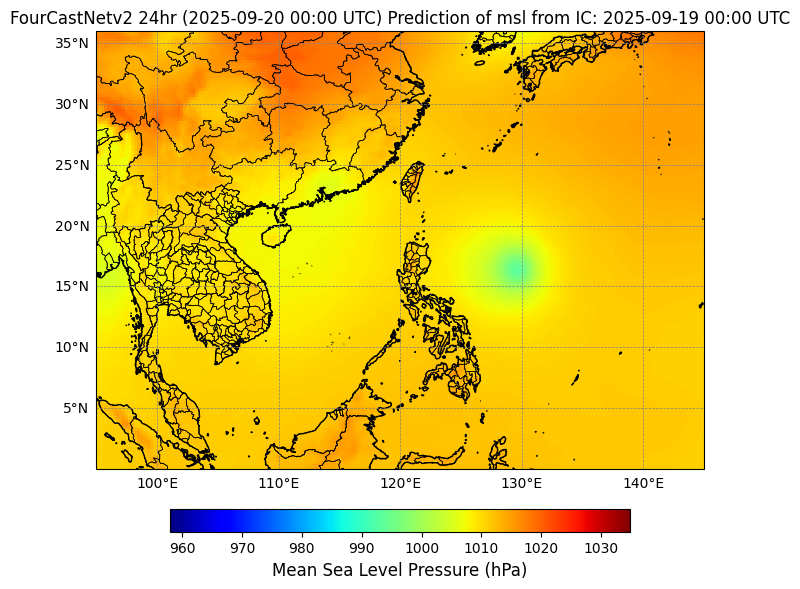

Data shape: (721, 1440)


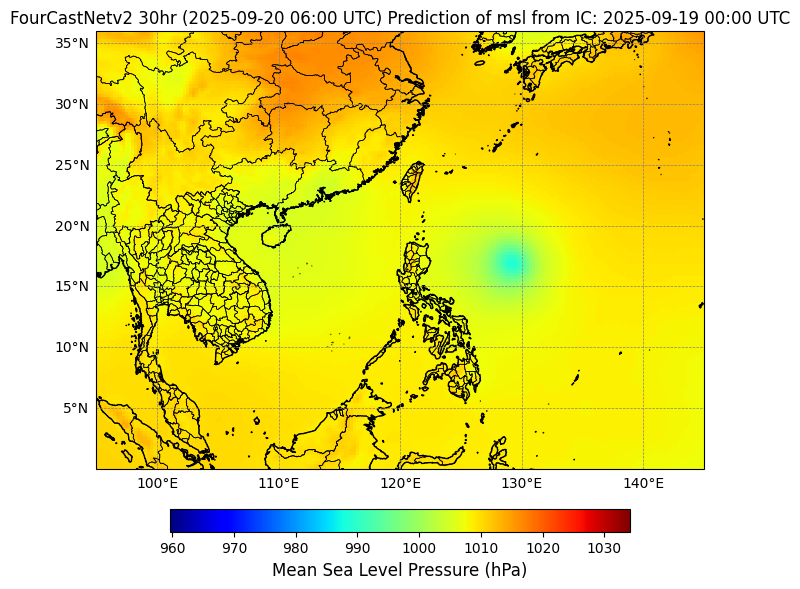

Data shape: (721, 1440)


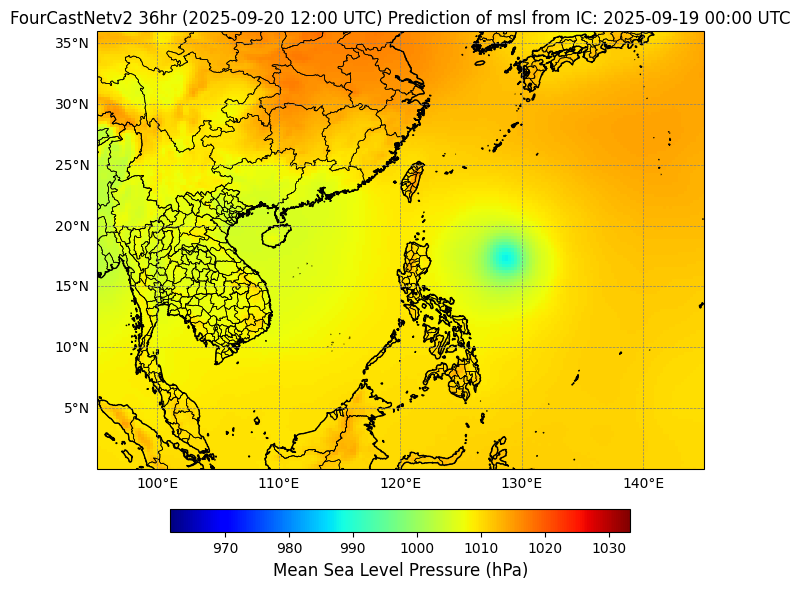

In [7]:
hurricane_prediction_plot(predictions=ds, variable='msl', t=3)
hurricane_prediction_plot(predictions=ds, variable='msl', t=4)
hurricane_prediction_plot(predictions=ds, variable='msl', t=5)
hurricane_prediction_plot(predictions=ds, variable='msl', t=6)

# Create GIF animation of MSLP frames

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

def save_hurricane_prediction_frame(predictions, variable, t, out_dir, huh=False):
    dat = predictions[variable].values[t]
    if huh:
        dat = dat[0]
    if variable in ['sp', 'msl']:
        dat = dat / 100

    projection = ccrs.PlateCarree()

    
    #ADJUST EXTENT
    #KATRINA 2005
    #extent = [-98, -70, 21, 44]
    #ERIN 2025
    #extent = [-85, -60, 17, 41]
    #HARVEY 2017
    #extent = [-105,-70,17,40]
    #PATRICIA 2015
    #extent = [-120,-95,10,30]
    #MARIA 2017
    #extent = [-85,-30,10,45]
    #SE ASIA
    extent = [95, 145, 0, 36]
    #carribean
   # extent = [-95, -55, 5, 35]


    

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)

    lons = predictions.longitude.values
    lats = predictions.latitude.values
    lon2d, lat2d = np.meshgrid(lons, lats)
    
    im = ax.pcolormesh(lon2d, lat2d, dat, transform=ccrs.PlateCarree(),
                       cmap="jet", shading="auto",vmin=990,vmax=1025)
    
    # Grab times from the dataset
    ic_dt = pd.to_datetime(ds.time.values)                      # scalar IC time (UTC)
    lead_hours = int(ds.step.values[t] / np.timedelta64(1, 'h'))  # lead in hours for frame t
    valid_dt = pd.to_datetime(ds.valid_time.values[t])          # valid time for frame t (UTC)
    
    # Nice strings
    ic_str = ic_dt.strftime("%Y-%m-%d %H:%M UTC")
    valid_str = valid_dt.strftime("%Y-%m-%d %H:%M UTC")
    
    ax.set_title(
        f"FourCastNetv2 {lead_hours}hr ({valid_str}) Prediction of {variable} "
        f"from IC: {ic_str}",
        fontsize=12
    )
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
    cbar.set_label(f"{variable_info[variable]['name']} ({variable_info[variable]['unit']})", fontsize=12)

    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
    gl.top_labels = False
    gl.right_labels = False

    os.makedirs(out_dir, exist_ok=True)
    #ADJUST FILE NAME HERE
    frame_path = os.path.join(out_dir, f"melissa_1025_{variable}_t{t:02d}.png")
    plt.savefig(frame_path, dpi=150)
    plt.close()

from PIL import Image
#ADJUST GIF NAME HERE
def make_gif_from_frames(output_dir, variable, num_frames, gif_name="melissa_1025.gif"):
    frames = []
    for t in range(num_frames):
        #ADJUST FILE NAME HERE
        frame_file = os.path.join(output_dir, f"melissa_1025_{variable}_t{t:02d}.png")
        if os.path.exists(frame_file):
            frames.append(Image.open(frame_file))
        else:
            print(f"Warning: Missing frame {frame_file}")

    if frames:
        gif_path = os.path.join(output_dir, gif_name)
        frames[0].save(
            gif_path,
            save_all=True,
            append_images=frames[1:],
            duration=300,
            loop=0
        )
        print(f"✅ Saved GIF to {gif_path}")
    else:
        print("❌ No frames found. GIF not created.")


NameError: name 'extent' is not defined

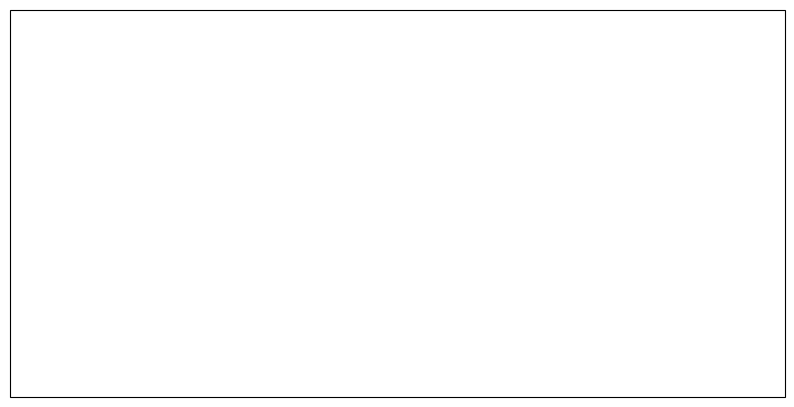

In [9]:
# Set up
#ADJUST DIRECTORY NAME HERE
output_dir = "/home/jovyan/melissa_1025_gif_frames"
variable = "msl"
timesteps = 40  # or however many you want <41

# Save PNGs
for t in range(timesteps):
    save_hurricane_prediction_frame(ds, variable, t, output_dir)

# Create GIF
make_gif_from_frames(output_dir, variable, timesteps)


# Plot Predicted Storm Track Using Minimum MSLP

In [2]:
import pygrib
import numpy as np
import pandas as pd
from datetime import datetime

def _grib_get(msg, key, default=None):
    try:
        return msg[key]
    except Exception:
        return default

def extract_track(grib_file, extent=None):
    """
    Extract minimum MSLP track from a GRIB2.
    Works for GFS (prmsl@meanSea) and ERA5 (msl).
    extent = [lon_min, lon_max, lat_min, lat_max] (deg)
    """
    grbs = pygrib.open(grib_file)

    # Prefer GFS naming first, then ERA5 naming
    try:
        msgs = grbs.select(shortName='prmsl', typeOfLevel='meanSea')
    except Exception:
        msgs = grbs.select(shortName='msl')  # ERA5

    if not msgs:
        grbs.close()
        raise ValueError("No MSLP found (tried prmsl@meanSea and msl).")

    track = []

    # Precompute global lat/lon once if not subsetting
    global_lats = global_lons = None
    if extent is None:
        global_lats, global_lons = msgs[0].latlons()

    # For ERA5, compute step from valid time difference
    first_valid = None

    for msg in msgs:
        if extent is not None:
            lon_min, lon_max, lat_min, lat_max = extent
            data, lats, lons = msg.data(lat1=lat_min, lat2=lat_max,
                                        lon1=lon_min, lon2=lon_max)
        else:
            data = msg.values
            lats, lons = global_lats, global_lons

        if np.ma.isMaskedArray(data) and data.mask.all():
            continue

        idx = np.unravel_index(np.ma.argmin(data), data.shape)
        min_hPa = float(data[idx]) / 100.0
        lat_min, lon_min = float(lats[idx]), float(lons[idx])

        valid_time = msg.validDate  # present in both ERA5 and GFS
        if first_valid is None:
            first_valid = valid_time

        # Try several keys; fall back to time delta for ERA5
        step = _grib_get(msg, "forecastTime")
        if step is None:
            step = _grib_get(msg, "step")
        if step is None:
            step_range = _grib_get(msg, "stepRange")  # e.g., "0", "6", or "0-6"
            if isinstance(step_range, str):
                if "-" in step_range:
                    # use the end of the range
                    step = int(step_range.split("-")[-1])
                else:
                    step = int(step_range)
        if step is None:
            # compute from valid time difference (ERA5 reanalysis)
            step = int((valid_time - first_valid).total_seconds() // 3600)

        track.append({
            "step_hours": int(step),
            "valid_time": valid_time,
            "lat": lat_min,
            "lon": lon_min,
            "mslp_hPa": min_hPa
        })

    grbs.close()
    return pd.DataFrame(track)


In [3]:
import os

#os.chdir("/home/jovyan/gfs_aws_downloads//")
# Atlantic basin (approx)
extent = [99, 132, 10, 25]


era5 = extract_track("/home/jovyan/fourcastnetv2/era5_fcnv2_20251001_0600.grib2", extent=extent)
#print(track_df)


In [4]:
def plot_tracks(
    track_list,
    labels,
    colors,
    linestyles=None,
    linewidths=None,            # NEW: line thickness
    region_extent=None,
    annotate_flags=None,
    annotate_every=1,
    title="Typhoon Paolo Track Comparison",
    outfile="tracks.png",
    dpi=180
):
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20, 18), subplot_kw={'projection': proj})

    ax.coastlines(resolution='10m', linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    try:
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.3)
    except Exception:
        pass

    if region_extent:
        ax.set_extent(region_extent, crs=proj)
    else:
        ax.set_global()

    if annotate_flags is None:
        annotate_flags = [True] * len(track_list)
    if linestyles is None:
        linestyles = ["-"] * len(track_list)
    if linewidths is None:
        linewidths = [2.5] * len(track_list)  # default thickness

    for track_df, label, color, style, lw, do_annot in zip(track_list, labels, colors, linestyles, linewidths, annotate_flags):
        ax.plot(
            track_df["lon"], track_df["lat"],
            linestyle=style, linewidth=lw,
            marker="o", markersize=4,
            color=color, label=label,
            transform=proj
        )

        # optional text labels
        if do_annot and "step_hours" in track_df.columns:
            for i, (_, row) in enumerate(track_df.iterrows()):
                if i % annotate_every != 0:
                    continue
                ax.text(
                    row["lon"], row["lat"], f"{int(row['step_hours'])}h",
                    fontsize=7, fontweight="bold",
                    ha="left", va="bottom", transform=proj,
                    path_effects=[pe.withStroke(linewidth=3, foreground="white")]
                )

    ax.set_title(title, fontsize=16)
    ax.legend()
    plt.savefig(outfile, dpi=dpi, bbox_inches="tight")
    plt.show()


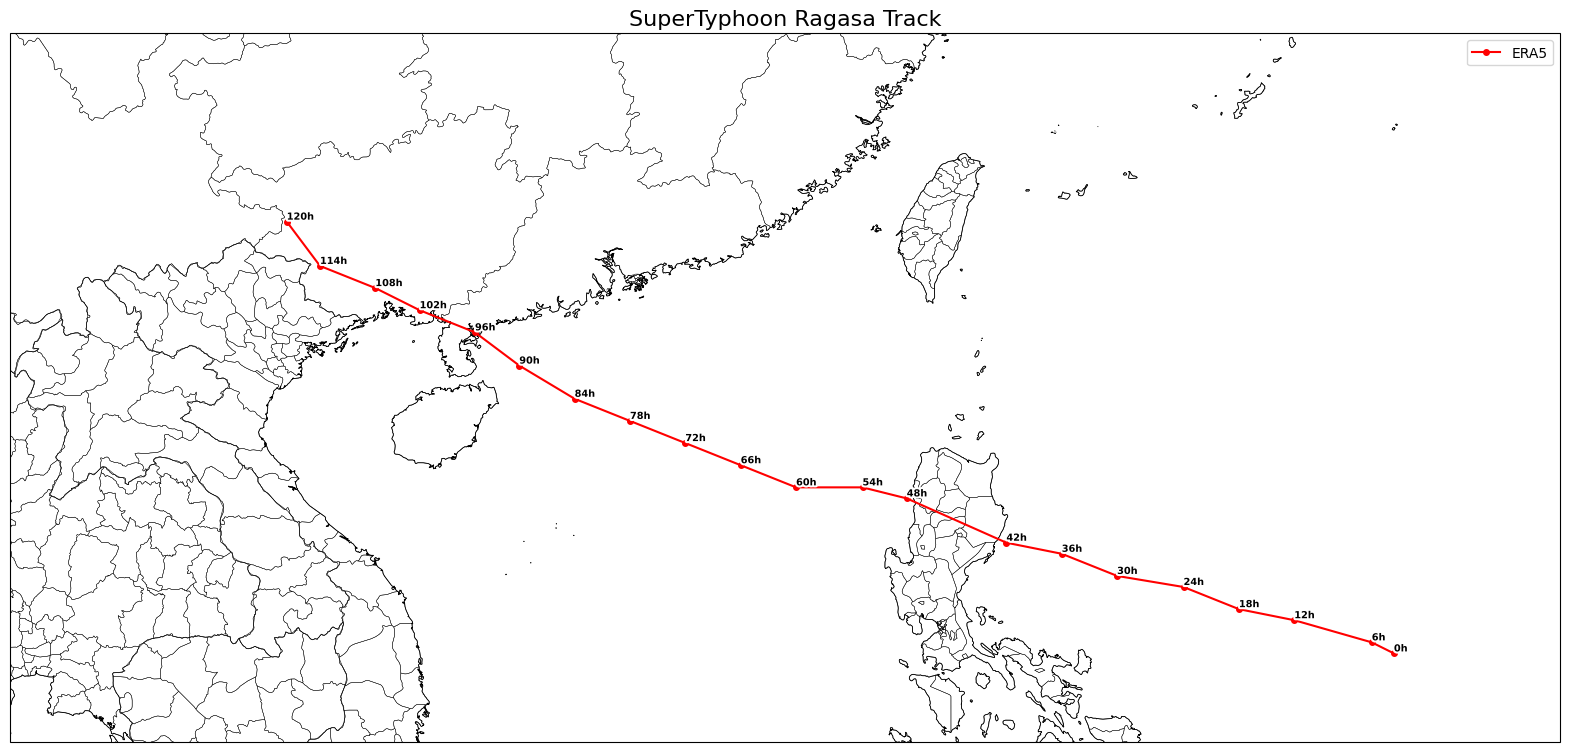

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import matplotlib.patheffects as pe


start, end = 0, 21
era5_track = era5.iloc[start:end]

plot_tracks(
    track_list=[era5_track],
    labels=["ERA5"],
    colors=["red"],
    linestyles=["-"],         # optional
    linewidths=[1.5],         # optional
    annotate_flags=[True],   # ERA5 truth usually has no step_hours
    region_extent=[100, 135, 12, 28],
    title="SuperTyphoon Ragasa Track"
)


## Use ECMWF Integrated Forecasting System (IFS) as Initial Condition

Free IFS data is available in a 10 day window. Data pulled from before 10 days is accessible to ECMWF members or by permission.
The github contains an IFS IC file for 20251001






In [ ]:
from ecmwf.opendata import Client

#ENTER DATA INTO IFS_DATA DIRECTORY

os.chdir("/home/jovyan/IFS_data/")
c = Client(source="ecmwf", model="ifs", resol="0p25")

#DATE="20251001"; TIME=0  # or latest()

c.retrieve(
    #date=DATE,
    #time=TIME,
    type="fc", 
    step=0,
    levtype="pl",
    levelist=[1000,925,850,700,600,500,400,300,250,200,150,100,50],
    param=["t","u","v","gh","r","10u","10v","2t","sp","msl","tcwv","100u","100v"],   # make sure 'r' is included
    target="ifs_ic_pl.grib2",
)

# Single levels as before
c.retrieve(
    #date=DATE,
    #time=TIME,
    stream="oper",
    type="fc",
    step=0,
    levtype="sfc",
    param=["10u","10v","2t","sp","msl","tcwv","100u","100v"],
    target="ifs_single_t0.grib2",
)

# Merge and delete individual files

#CHANGE DATE
import os
os.system("cat ifs_ic_pl.grib2 ifs_single_t0.grib2 > ifs_ic_{date}.grib2")
os.system("rm -r ifs_ic_pl.grib2 ifs_single_t0.grib2")


# IFS data needs to change geopotential height to geopotential and scale

You will need the eccodes package to edit grib files

```pip install eccodes```

To change the gh variable to z use

```grib_set -s shortName=z -w shortName =gh <file_in.grib2> <file_out.grib2>```

To scale gh to z you need to multiply the values by gravity constant g
```grib_set -w paramId=129 -s scaleValuesBy=9.80665 <file_in.grib2> <file_out.grib2>```

# Download NOAA's GFS Forecast to Compare

The following script will download data and then concatinate the MSLP data into a single file for plotting

```
# 1. Download only the needed forecast hours from AWS
for F in $(seq -w 0 6 240); do
  URL="https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20251001/06/atmos/gfs.t06z.pgrb2.0p25.f${F}"
  echo "[INFO] Downloading f${F}"
  curl -fsS -O "$URL"
done

# 2. Combine only PRMSL fields from all those files into one GRIB2
grib_copy -w shortName=prmsl,typeOfLevel=meanSea gfs.t06z.pgrb2.0p25.f??? gfs_mslp_20251001_06z_0p25.grib2

# 3. Verify
grib_ls -w shortName=prmsl,typeOfLevel=meanSea gfs_mslp_20251001_06z_0p25.grib2 | head
```

# Download ERA5 data to compare

The following cell will download era5 data in 6 hour intervals for just MSLP.

In [ ]:
import cdsapi
c = cdsapi.Client()

#ADJUST DATES AS NEEDED

c.retrieve(
    "reanalysis-era5-single-levels",
    {
        "product_type": "reanalysis",
        "variable": ["mean_sea_level_pressure"],
        "date": "2025-10-01/2025-10-31",
        "time": ["00:00","06:00","12:00","18:00"],
        "format": "grib",
        # "area": [36, 95, 0, 135],
        # "grid": [0.25, 0.25],
    },
    "era5_mslp_6h_202510.grib"
)


# Compare Tracks from different initial conditions

You will need to produce a new FCNv2 prediction for the IFS IC

```ai-models --file ~/FCN4AWS/ifs_ic_scaled_20251001_0600.grib2 --time 0600 --path ifs_ic_20251001_0600_output.grib2```

In [14]:
extent=[100, 135, 12, 28]
#ifs = extract_track("/home/jovyan/fourcastnetv2/ifs_ic_20251001_0600_output.grib2", extent=extent)
#gfs = extract_track("/home/jovyan/gfs_aws_downloads/gfs_mslp_20251001_06z_0p25.grib2", extent=extent)
true = extract_track("/home/jovyan/era5_mslp_6h_202510.grib", extent = extent)

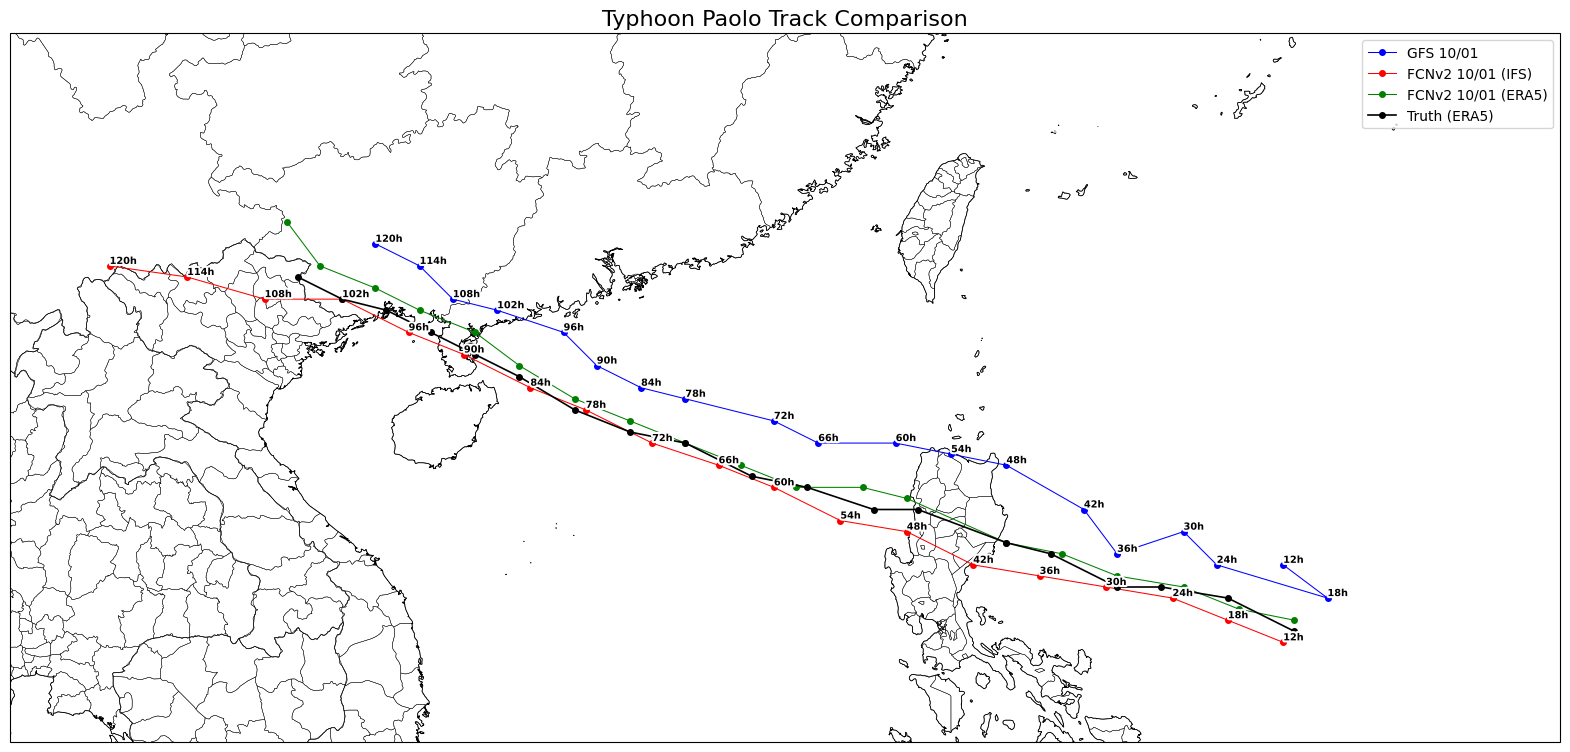

In [25]:
# Slice windows as you had:
start = 2
end = 21


gfs_track  = gfs.iloc[start:end]
ifs_track  = ifs.iloc[start:end]
era5_track = era5.iloc[start:end]
true_track = true.iloc[start+1:end+1]  # no step_hours
os.chdir("/home/jovyan/")

plot_tracks(
    track_list=[gfs_track, ifs_track, era5_track, true_track],
    labels=["GFS 10/01" ,"FCNv2 10/01 (IFS)", "FCNv2 10/01 (ERA5)", "Truth (ERA5)"],
    colors=["blue", "red", "green", "black"],
    linestyles=["-", "-","-","-"],
    linewidths=[.75,.75,.75,1.20],# ← line styles for each
    annotate_flags=[True, True, False, False], #False for ERA5 data (no time steps)
    region_extent=[100, 135, 12, 28]
)


# Minimum MSLP Time Series

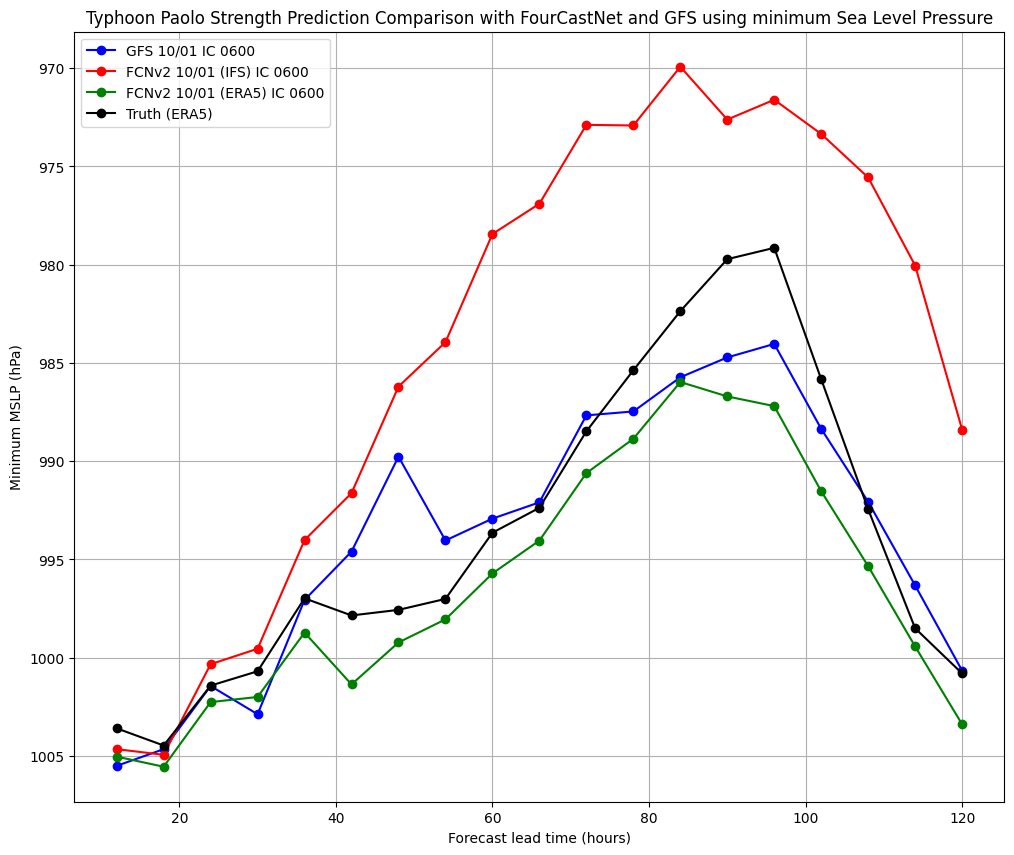

In [26]:
import matplotlib.pyplot as plt

# Subset to the first 19 steps for consistency
end = 21
start = 2

gfs_series   = gfs.iloc[start:end].copy()
ifs_series   = ifs.iloc[start:end].copy()
era5_series  = era5.iloc[start:end].copy()
true_series  = true.iloc[start+1:end+1].copy()

plt.figure(figsize=(12,10))

labels=["FCNv2 10/01 IC 1800", "FCNv2 10/01 IC 0600"],

# Plot GFS
plt.plot(gfs_series["step_hours"], gfs_series["mslp_hPa"], "-o", color="blue", label="GFS 10/01 IC 0600")

# Plot FCNv2
plt.plot(ifs_series["step_hours"], ifs_series["mslp_hPa"], "-o", color="red", label="FCNv2 10/01 (IFS) IC 0600")

plt.plot(era5_series["step_hours"], era5_series["mslp_hPa"], "-o", color="green", label="FCNv2 10/01 (ERA5) IC 0600")


plt.plot(era5_series["step_hours"], true_series["mslp_hPa"], "-o", color="black", label="Truth (ERA5)")

plt.gca().invert_yaxis()  # lower pressure = stronger storm
plt.xlabel("Forecast lead time (hours)")
plt.ylabel("Minimum MSLP (hPa)")
plt.title("Typhoon Paolo Strength Prediction Comparison with FourCastNet and GFS using minimum Sea Level Pressure")
plt.grid(True)
plt.legend()
plt.savefig("/home/jovyan/fourcastnetv2/paolo_comparison_t_Series")
plt.show()

MAE / RMSE (hPa):
GFS  (2.1466835526315853, 2.954074072727842)
IFS  (9.654099506578973, 11.280495381785263)
ERA5 FCNv2 (2.774712171052628, 3.4307735095519734)


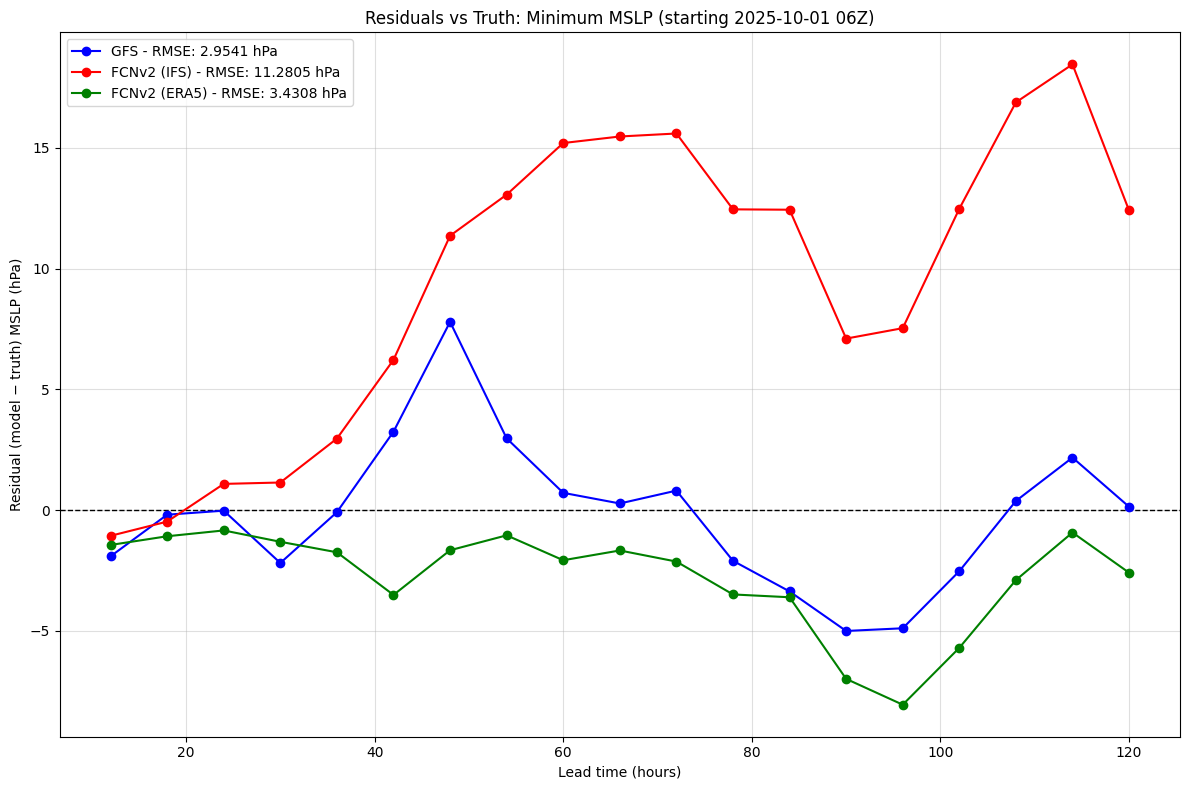

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- make copies of your slices (first 33 steps as you did) ---
end = 21
start = 2

gfs_series   = gfs.iloc[start:end].copy()
ifs_series   = ifs.iloc[start:end].copy()
era5_series  = era5.iloc[start:end].copy()
true_series  = true.iloc[start+1:end+1].copy()

# Ensure datetime and lead-time exist
for df in (gfs_series, ifs_series, era5_series, true_series):
    df["valid_time"] = pd.to_datetime(df["valid_time"])

# Merge each model with truth on valid_time
def merge_with_truth(model_df, truth_df):
    cols = ["valid_time", "mslp_hPa", "step_hours"] if "step_hours" in model_df.columns else ["valid_time", "mslp_hPa"]
    m = model_df[cols].rename(columns={"mslp_hPa":"mslp_model"})
    t = truth_df[["valid_time","mslp_hPa"]].rename(columns={"mslp_hPa":"mslp_truth"})
    out = pd.merge(m, t, on="valid_time", how="inner")
    # derive lead time if missing (truth may not have step_hours)
    if "step_hours" not in out.columns:
        out["step_hours"] = (out["valid_time"] - out["valid_time"].iloc[0]).dt.total_seconds()/3600.0
    return out

gfs_m   = merge_with_truth(gfs_series, true_series)
ifs_m   = merge_with_truth(ifs_series, true_series)
era5_m  = merge_with_truth(era5_series, true_series)

# Compute residuals (model - truth)
for df in (gfs_m, ifs_m, era5_m):
    df["residual_hPa"] = df["mslp_truth"] - df["mslp_model"]

# Optional: quick skill stats
def skill(df):
    err = df["residual_hPa"].to_numpy()
    mae = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    return mae, rmse

print("MAE / RMSE (hPa):")
print("GFS ", skill(gfs_m))
print("IFS ", skill(ifs_m))
print("ERA5 FCNv2", skill(era5_m))

# --- Plot residuals vs lead time ---
plt.figure(figsize=(12,8))
plt.axhline(0, color="k", linewidth=1, linestyle="--")

plt.plot(gfs_m["step_hours"],  gfs_m["residual_hPa"],  "-o", label=f"GFS - RMSE: {skill(gfs_m)[1]:.4f} hPa",        color="blue")
plt.plot(ifs_m["step_hours"],  ifs_m["residual_hPa"],  "-o", label=f"FCNv2 (IFS) - RMSE: {skill(ifs_m)[1]:.4f} hPa", color="red")
plt.plot(era5_m["step_hours"], era5_m["residual_hPa"], "-o", label=f"FCNv2 (ERA5) - RMSE: {skill(era5_m)[1]:.4f} hPa",color="green")

plt.grid(True, alpha=0.4)
plt.xlabel("Lead time (hours)")
plt.ylabel("Residual (model − truth) MSLP (hPa)")
plt.title("Residuals vs Truth: Minimum MSLP (starting 2025-10-01 06Z)")
plt.legend()
plt.tight_layout()
plt.savefig("/home/jovyan/fourcastnetv2/paolo_residual_strength_comparison_t_Series")
plt.show()


Mean Abs Error (hPa), RMSE (hPa), Mean position error (km)
GFS:  (2.2581069444444526, 3.0348404707037826, 193.28461040533054)
IFS:  (9.501098090277802, 11.214525251494818, 117.99973996512001)
ERA5 FCNv2:  (2.7850434027777737, 3.471569482081297, 38.82843570002905)


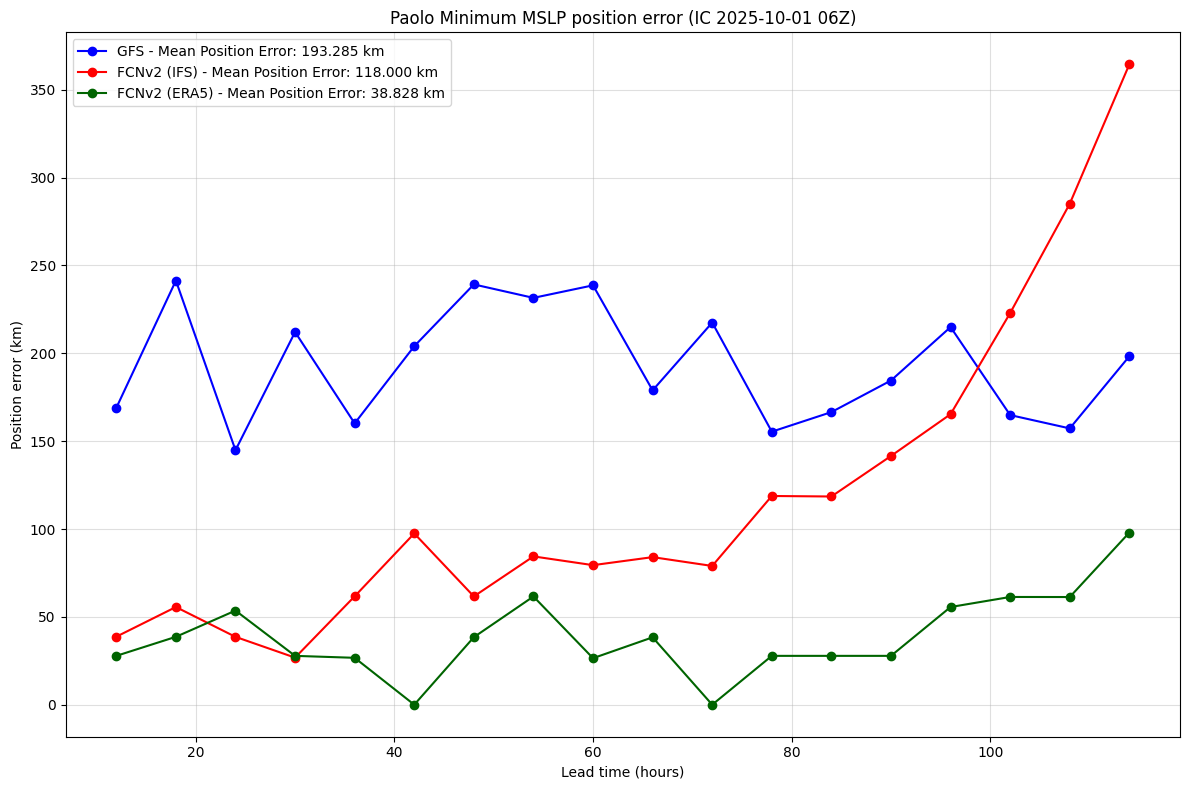

In [28]:
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt

end = 21
start = 2

gfs_series   = gfs.iloc[start:end].copy()
ifs_series   = ifs.iloc[start:end].copy()
era5_series  = era5.iloc[start:end].copy()
true_series  = true.iloc[start+1:end].copy()

# Great-circle (haversine) distance in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.009  # Earth radius (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    sigma = np.arccos(np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(dlon))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * sigma

# Merge model and truth as before
def merge_with_truth_coords(model_df, truth_df):
    cols = ["valid_time", "mslp_hPa", "lat", "lon", "step_hours"] if "step_hours" in model_df.columns else ["valid_time", "mslp_hPa", "lat", "lon"]
    m = model_df[cols].rename(columns={"mslp_hPa": "mslp_model", "lat": "lat_model", "lon": "lon_model"})
    t = truth_df[["valid_time", "mslp_hPa", "lat", "lon"]].rename(columns={"mslp_hPa": "mslp_truth", "lat": "lat_truth", "lon": "lon_truth"})
    out = pd.merge(m, t, on="valid_time", how="inner")

    if "step_hours" not in out.columns:
        out["step_hours"] = (out["valid_time"] - out["valid_time"].iloc[0]).dt.total_seconds() / 3600

    # Residuals
    out["residual_hPa"] = out["mslp_model"] - out["mslp_truth"]
    out["distance_km"] = haversine(out["lat_model"], out["lon_model"], out["lat_truth"], out["lon_truth"])
    return out

gfs_m   = merge_with_truth_coords(gfs_series, true_series)
ifs_m   = merge_with_truth_coords(ifs_series, true_series)
era5_m  = merge_with_truth_coords(era5_series, true_series)

# Quick stats
def skill(df):
    err_p = df["residual_hPa"].to_numpy()
    err_d = df["distance_km"].to_numpy()
    return np.mean(np.abs(err_p)), np.sqrt(np.mean(err_p**2)), np.mean(err_d)

print("Mean Abs Error (hPa), RMSE (hPa), Mean position error (km)")
print("GFS: ", skill(gfs_m))
print("IFS: ", skill(ifs_m))
print("ERA5 FCNv2: ", skill(era5_m))

# --- Plot distance error vs lead time ---
plt.figure(figsize=(12,8))
plt.plot(gfs_m["step_hours"],  gfs_m["distance_km"],  "-o", label=f"GFS - Mean Position Error: {skill(gfs_m)[2]:.3f} km", color="blue")
plt.plot(ifs_m["step_hours"],  ifs_m["distance_km"],  "-o", label=f"FCNv2 (IFS) - Mean Position Error: {skill(ifs_m)[2]:.3f} km", color="red")
plt.plot(era5_m["step_hours"], era5_m["distance_km"], "-o", label=f"FCNv2 (ERA5) - Mean Position Error: {skill(era5_m)[2]:.3f} km", color="darkgreen")
plt.grid(True, alpha=0.4)
plt.xlabel("Lead time (hours)")
plt.ylabel("Position error (km)")
plt.title("Paolo Minimum MSLP position error (IC 2025-10-01 06Z)")
plt.legend()
plt.tight_layout()
plt.savefig("/home/jovyan/fourcastnetv2/paolo_residual_position_comparison_t_Series")
plt.show()


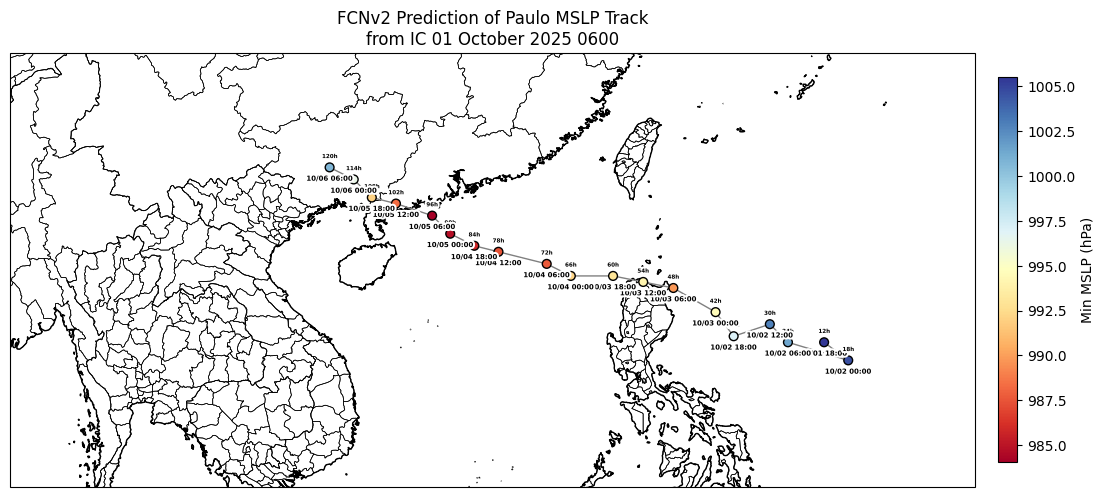

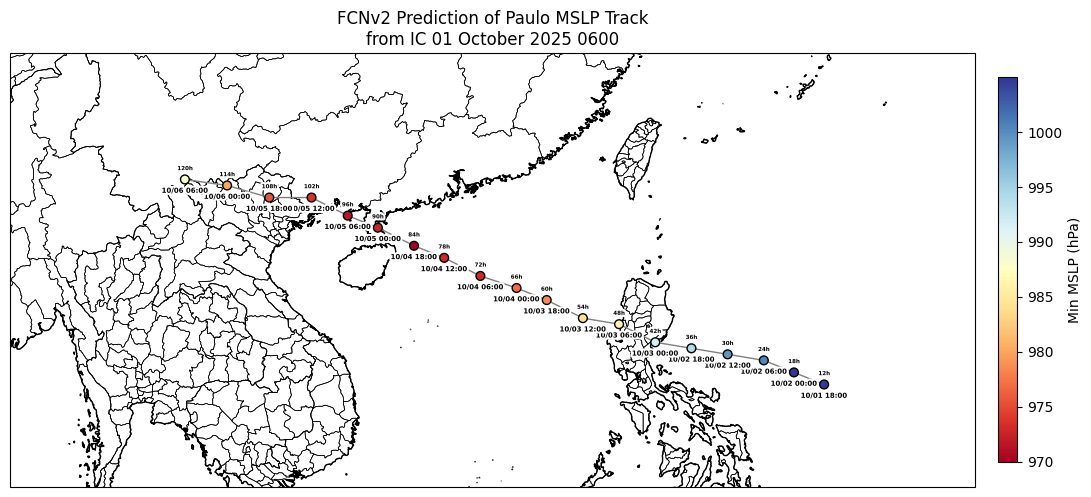

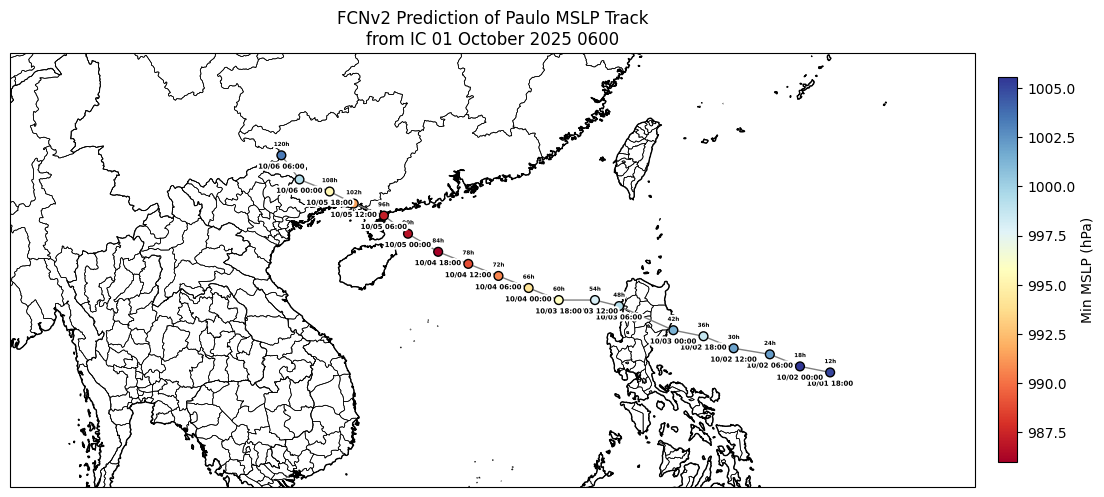

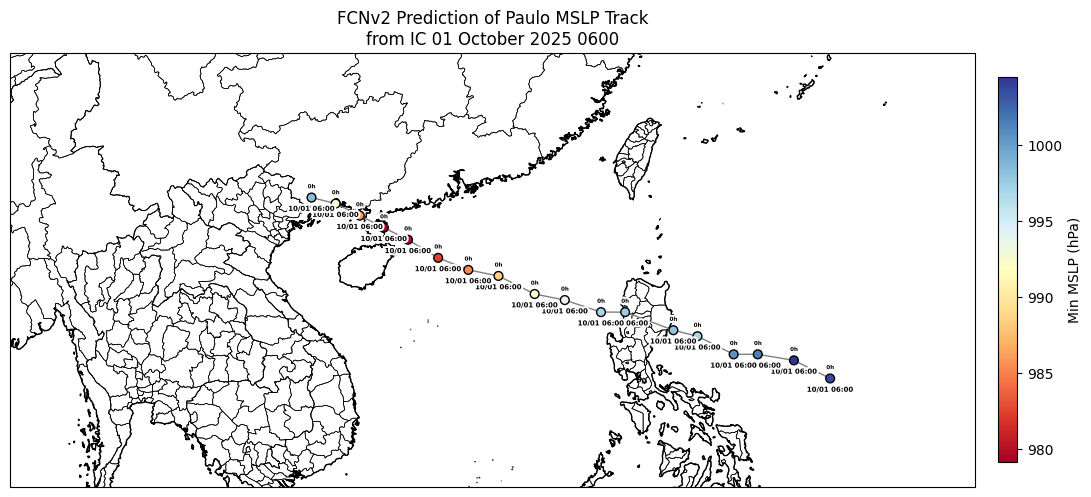

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as pe

def plot_track_combined(track_df, region_extent=None):
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(15,10), subplot_kw={'projection': proj})

    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)

    if region_extent:
        ax.set_extent(region_extent, crs=proj)
    else:
        ax.set_global()

    # map mslp_hPa values to a colormap
    sc = ax.scatter(
        track_df["lon"], track_df["lat"],
        c=track_df["mslp_hPa"], cmap="RdYlBu", s=40, edgecolor="k",
        transform=proj, zorder=3
    )

    # also draw the track line
    ax.plot(track_df["lon"], track_df["lat"], "-", color="gray", lw=1, transform=proj)
    # Define your initialization time
    init_time = pd.Timestamp("2025-10-01 06:00")  # adjust to your IC
    
    for _, row in track_df.iterrows():
        step = row["step_hours"]
    
        # only label every 12h (skip intermediate)
        if step % 6 == 0:
            valid_time = init_time + pd.Timedelta(hours=step)
    
            # Above: forecast hour
            ax.annotate(
                f"{step}h",
                xy=(row["lon"], row["lat"]),
                xytext=(0, 6), textcoords="offset points",
                fontsize=4, fontweight="bold",
                ha="center", va="bottom", transform=proj,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")]
            )
    
            # Below: valid time (MM/DD HH:MM)
            ax.annotate(
                valid_time.strftime("%m/%d %H:%M"),
                xy=(row["lon"], row["lat"]),
                xytext=(0, -6), textcoords="offset points",
                fontsize=5, fontweight = "bold",
                ha="center", va="top", transform=proj,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")]
            )
    # add colorbar
    cbar = plt.colorbar(sc, orientation="vertical", pad=0.02, shrink=0.5, ax=ax)
    cbar.set_label("Min MSLP (hPa)")

    ax.set_title("FCNv2 Prediction of Paulo MSLP Track\nfrom IC 01 October 2025 0600")
   # plt.savefig("Paulo_track_20251001_0600.png", dpi=150, bbox_inches="tight")
    plt.show()
#track_first35 = track_df.iloc[0:24]

end = 21
start = 2

gfs_series   = gfs.iloc[start:end].copy()
ifs_series   = ifs.iloc[start:end].copy()
era5_series  = era5.iloc[start:end].copy()
true_series  = true.iloc[start+1:end].copy()

plot_track_combined(gfs_series, region_extent = [95, 135, 10, 28])
plot_track_combined(ifs_series, region_extent = [95, 135, 10, 28])
plot_track_combined(era5_series, region_extent = [95, 135, 10, 28])
plot_track_combined(true_series, region_extent = [95, 135, 10, 28])
plt.savefig("Paulo_track_20251001_0600.png", dpi=150, bbox_inches="tight")